<a href="https://colab.research.google.com/github/anishjohnson/Face-Emotion-Recognition/blob/main/FER/Colab%20Notebook/Face_Emotion_Recognition_Anish_Johnson.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Face Emotion Recognition**










# **Objective**
Our objective is to solve the above mentioned challenge by applying deep learning algorithms to live video data inorder to recognize the facial emotions and categorize them accordingly.

# **Dataset used**
We have utilized the [FER 2013](https://www.kaggle.com/datasets/msambare/fer2013) dataset provided on Kaggle.<br>
The data consists of 48x48 pixel grayscale images of faces. The faces have been automatically registered so that the face is more or less centred and occupies about the same amount of space in each image.<br>

The task is to categorize each face based on the emotion shown in the facial expression into one of seven categories (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral). The training set consists of 28,709 examples and the public test set consists of 3,589 examples.

In [ ]:
!nvidia-smi
!nvcc -V

Wed Mar 15 14:49:58 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P0    31W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### **Let's Begin:**

# **Data Exploration:**

**Lets start by importing the required libraries.**

In [1]:
# Basic python libraries.
import glob
import os.path as osp
import datetime
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
import itertools
# Get rid of warnings!
import torchvision
from torchvision import models
import warnings
warnings.filterwarnings('ignore')
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
import torch.optim as optim
import torch.utils.data as data
import shutil
import time
from tqdm import tqdm
print('Above libraries have been imported.')

Above libraries have been imported.


In [2]:
from google.colab import drive 
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
file_path = '/content/drive/MyDrive/Colab Notebooks/Project-AI/Dataset/FER-2013-Dataset.zip'

In [4]:
# Load the FER2013 dataset
from zipfile import ZipFile
with ZipFile(file_path , 'r') as ZipFile:
  ZipFile.extractall()
  print('Zip file extracted successfully')

Zip file extracted successfully


**Seperate the Training and Validation Data.**

**Have a look at our data.**

**Perform some Data Augmentation on train and validations sets.**

# **Data Preprocessing:**

In [5]:
class ImageTransform():
    def __init__(self, resize, mean, std):
        self.data_transform = {
            'train': transforms.Compose([
                transforms.RandomResizedCrop(resize, scale = (0.5, 1.0)),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize((0.5), (0.5))
            ]),
            
            'val': transforms.Compose([
                transforms.Resize(resize),
                transforms.CenterCrop(resize),
                transforms.ToTensor(),
                transforms.Normalize((0.5), (0.5))
            ])
        }
        
    def __call__(self, img, phase='train'):
        return self.data_transform[phase](img)

In [6]:
resize = 48
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

transform = ImageTransform(resize, mean, std)

In [7]:
def make_datapath_list(phase):
    rootpath = '/content/'
    target_path = osp.join(rootpath + phase + '/**/*.jpg')
    print(target_path)
    
    path_list = []
    
    for path in glob.glob(target_path):
        path_list.append(path)
        
    return path_list

In [8]:
train_list = make_datapath_list('train')
val_list = make_datapath_list('test')

class MyDataset(data.Dataset):
    def __init__(self, file_list, transform=None, phase="train"):
        self.file_list = file_list
        self.transform = transform
        self.phase = phase
        
    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        
        img_transformed = self.transform(img, self.phase)
        
        label = img_path.split('/')[3]
        
        if label == "angry":
            label = 0
        elif label == "disgust":
            label = 1
        elif label == "fear":
            label = 2
        elif label == "happy":
            label = 3
        elif label == "neutral":
            label = 4
        elif label == "sad":
            label = 5
        elif label == "surprise":
            label = 6
        return img_transformed, label


train_set = MyDataset(train_list, transform = ImageTransform(resize, mean, std), phase = 'train')
val_set = MyDataset(val_list, transform = ImageTransform(resize, mean, std), phase = 'val')

index = 0
print(train_set.__len__())
print(train_set.__getitem__(index))

print(val_set.__len__())
print(val_set.__getitem__(index))

batch_size = 64

train_loader = torch.utils.data.DataLoader(train_set, batch_size, shuffle = True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size, shuffle = False)

dataloader_dict = {"train": train_loader, "val": val_loader}


batch_iterator = iter(dataloader_dict["train"])

batch = next(batch_iterator)


inputs, labels = batch

print("All data have been loaded!!")

/content/train/**/*.jpg
/content/test/**/*.jpg
28709
(tensor([[[-0.1765, -0.1765, -0.1686,  ..., -0.6157, -0.6078, -0.5843],
         [-0.1529, -0.1451, -0.1529,  ..., -0.6078, -0.6314, -0.6471],
         [-0.1686, -0.1922, -0.2627,  ..., -0.6000, -0.6549, -0.7098],
         ...,
         [-0.4431, -0.3176, -0.2078,  ...,  0.9373,  0.9922,  0.9686],
         [-0.5216, -0.3882, -0.2627,  ...,  0.9686,  0.9765,  0.9843],
         [-0.5686, -0.4588, -0.3412,  ...,  0.9529,  0.9608,  0.9922]]]), 1)
7178
(tensor([[[-0.2314, -0.2078, -0.1529,  ...,  0.2706,  0.2314,  0.2314],
         [-0.2235, -0.2157, -0.1294,  ...,  0.3490,  0.3412,  0.3333],
         [-0.1765, -0.1765, -0.1137,  ...,  0.4196,  0.4039,  0.3725],
         ...,
         [-0.1765, -0.1137, -0.0824,  ..., -0.7725, -0.7647, -0.7647],
         [-0.2471, -0.2549, -0.2549,  ..., -0.7020, -0.7412, -0.7725],
         [-0.2392, -0.2000, -0.2549,  ..., -0.6784, -0.5686, -0.6627]]]), 1)
All data have been loaded!!


**Now lets create our custom CNN model.**

# **Build CNN Model:**

**Before we start building the neural network lets understand some of the terms that we will be using.**

* **Model = sequential** : A Sequential model is appropriate for a plain stack of layers where each layer has exactly one input tensor and one output tensor.

* **Padding** = The padding parameter of the Keras Conv2D class can take one of two values: 'valid' or 'same'. Setting the value to “valid” parameter means that the input volume is not zero-padded and the spatial dimensions are allowed to reduce via the natural application of convolution.

* **Activation** = relu :The rectified linear activation function or ReLU for short is a piecewise linear function that will output the input directly if it is positive, otherwise, it will output zero. It has become the default activation function for many types of neural networks because a model that uses it is easier to train and often achieves better performance.

* **Maxpooling** = Maximum pooling, or max pooling, is a pooling operation that calculates the maximum, or largest, value in each patch of each feature map. The results are down sampled or pooled feature maps that highlight the most present feature in the patch, not the average presence of the feature in the case of average pooling.

* **Batch normalization** = Batch normalization is a technique for training very deep neural networks that standardizes the inputs to a layer for each mini-batch. This has the effect of stabilizing the learning process and dramatically reducing the number of training epochs required to train deep networks.

* **Dropout** = Dropout is a technique used to prevent a model from overfitting. Dropout works by randomly setting the outgoing edges of hidden units (neurons that make up hidden layers) to 0 at each update of the training phase.

* **Adam** = Adaptive Moment Estimation is an algorithm for optimization technique for gradient descent. The method is really efficient when working with large problem involving a lot of data or parameters. It requires less memory and is efficient. Intuitively, it is a combination of the ‘gradient descent with momentum’ algorithm and the ‘RMSP’ algorithm. It uses the squared gradients to scale the learning rate like RMSprop and it takes advantage of momentum by using moving average of the gradient instead of gradient itself like SGD with momentum.

In [ ]:
import torchvision
print(torchvision.models.alexnet())

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [9]:
import torch.nn as nn
import torch.nn.functional as F

class AlexNet(nn.Module):
    def __init__(self, num_classes=1000):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 128, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.maxpool = nn.AdaptiveMaxPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(512 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.maxpool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return F.log_softmax(x, dim=1)


#Training model


In [12]:
num_classes = 7
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = AlexNet(num_classes).to(device)
print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (maxpool): AdaptiveMaxPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=18432, out_features=4096, bias=True)
  

In [ ]:
checkpoint = torch.load('/content/drive/MyDrive/Colab Notebooks/Project-AI/model_saved/best_model.pth.tar')
for key in checkpoint:
    print(key)
        

# retrieve the model state dictionary from the checkpoint
model.load_state_dict(checkpoint['model_state_dict'])


epoch
model_state_dict
optimizer_state_dict
train_loss
train_acc
val_loss
val_acc


<All keys matched successfully>

In [ ]:
epochs = 2000
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# Load any other necessary variables from the checkpoint, such as the optimizer state dictionary
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
save_every = 50
# define your loss function
criterion = nn.CrossEntropyLoss()

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True, cooldown=0, min_lr=0.001, eps=1e-08)
# define your checkpoint callback function
def save_checkpoint(state, is_best, filename='checkpoint.pth.tar', save_every=save_every):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, '/content/drive/MyDrive/Colab Notebooks/Project-AI/model_saved/best_model.pth.tar')
    if state['epoch'] % save_every == 0:
        torch.save(state, f'checkpoint_epoch{state["epoch"]}.pth.tar')

# initialize variables for tracking training progress and best validation accuracy
train_losses = []
train_accs = []
val_losses = []
val_accs = []
best_val_acc = 0.0

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
# train the model
for epoch in range(epochs):
    start=time.time()
    # train for one epoch
    model.to(device)
    model.train()
    train_loss = 0.0
    train_acc = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        # zero the parameter gradients
        optimizer.zero_grad()

        # move inputs and labels to the same device as the model
        inputs = inputs.to(device)
        labels = labels.to(device)

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # update training loss and accuracy
        train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        train_acc += (predicted == labels).sum().item()

    # calculate average training loss and accuracy for the epoch
    train_loss = train_loss / len(train_loader.dataset)
    train_acc = train_acc / len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    # evaluate the model on the validation set
    model.eval()
    val_loss = 0.0
    val_acc = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            # move inputs and labels to the same device as the model
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            val_acc += (predicted == labels).sum().item()

    # calculate average validation loss and accuracy for the epoch
    val_loss = val_loss / len(val_loader.dataset)
    val_acc = val_acc / len(val_loader.dataset)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    # update the learning rate scheduler based on validation loss
    scheduler.step(-val_loss)

    # save checkpoint and best model
    is_best = val_acc > best_val_acc
    best_val_acc = max(val_acc, best_val_acc)
    save_checkpoint({
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss': train_loss,
        'train_acc': train_acc,
        'val_loss': val_loss,
        'val_acc': val_acc
    }, is_best)

    # print training progress for the epoch
    stop=time.time()
    print(f'Time: {stop-start} Epoch {epoch+1} Train Loss: {train_loss:.4f} Train Acc: {train_acc:.4f} Val Loss: {val_loss:.4f} Val Acc: {val_acc:.4f} Best Val Acc: {best_val_acc:.4f}')

print('Finished Training')

cuda
Time: 54.464271783828735 Epoch 1 Train Loss: 0.5516 Train Acc: 0.7996 Val Loss: 1.2681 Val Acc: 0.6293 Best Val Acc: 0.6293
Time: 50.76191854476929 Epoch 2 Train Loss: 0.5403 Train Acc: 0.8042 Val Loss: 1.3745 Val Acc: 0.6151 Best Val Acc: 0.6293
Time: 44.01735186576843 Epoch 3 Train Loss: 0.5304 Train Acc: 0.8068 Val Loss: 1.3882 Val Acc: 0.6282 Best Val Acc: 0.6293
Time: 44.0635941028595 Epoch 4 Train Loss: 0.5260 Train Acc: 0.8091 Val Loss: 1.3526 Val Acc: 0.6254 Best Val Acc: 0.6293
Time: 43.74465322494507 Epoch 5 Train Loss: 0.5194 Train Acc: 0.8100 Val Loss: 1.3274 Val Acc: 0.6262 Best Val Acc: 0.6293
Time: 44.55693173408508 Epoch 6 Train Loss: 0.5094 Train Acc: 0.8154 Val Loss: 1.4649 Val Acc: 0.6140 Best Val Acc: 0.6293
Time: 46.02272653579712 Epoch 7 Train Loss: 0.5169 Train Acc: 0.8132 Val Loss: 1.3593 Val Acc: 0.6280 Best Val Acc: 0.6293
Time: 49.97662854194641 Epoch 8 Train Loss: 0.5073 Train Acc: 0.8171 Val Loss: 1.3579 Val Acc: 0.6328 Best Val Acc: 0.6328
Time: 48.07

KeyboardInterrupt: ignored

#Save model

In [ ]:
model_dir = "AlexNet_model.h5"
model_weights_dir = "AlexNet_model_weighs.h5"

In [ ]:
# Save the whole model
model.save(model_dir)
model.save_weights(model_weights_dir)

# **Model evaluation:**

In [ ]:
from tensorflow.keras.models import load_model
weights_path = "/content/drive/MyDrive/Project-AI/model_saved/Fer_weights/AlexNetnew_model_weighs_200.h5"

def get_accuracy_from_weights(weights_path, val_set):
    # Load model from weights
    model = AlexNet((48,48,3),7) # replace create_model with your function to create the model architecture
    model.load_weights(weights_path)

    # Evaluate model on test data
    loss, accuracy = model.evaluate(val_set)

    return accuracy


In [ ]:
accuracy = get_accuracy_from_weights(weights_path, val_set)
print(accuracy)

In [ ]:
# Or using plotting 
# Create plots for accuracy and loss.
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
fig.set_size_inches(12,4)

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Training Accuracy vs Validation Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Training Loss vs Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

plt.show()

epoch
model_state_dict
optimizer_state_dict
train_loss
train_acc
val_loss
val_acc


<Figure size 432x288 with 0 Axes>

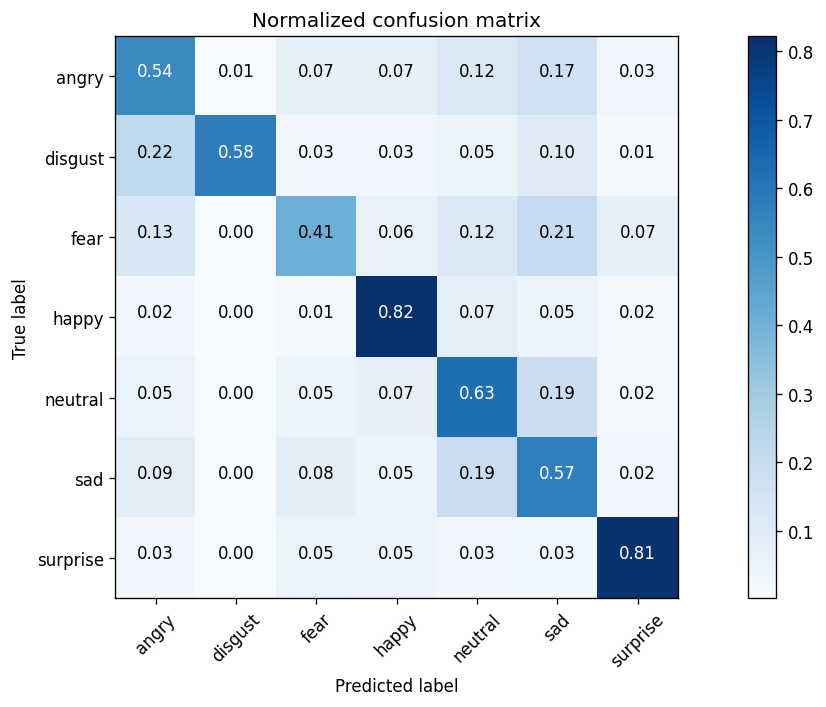

In [13]:
import numpy as np
import torch
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# load the checkpoint file
checkpoint = torch.load('/content/drive/MyDrive/Colab Notebooks/Project-AI/model_saved/best_model.pth.tar')
for key in checkpoint:
    print(key)
        

# retrieve the model state dictionary from the checkpoint
model.load_state_dict(checkpoint['model_state_dict'])

#compute predictions
model.eval()
y_pred = []
y_true = []
with torch.no_grad():
    for inputs, labels in val_set:
        inputs = inputs.to(device)
        inputs = inputs.unsqueeze(0)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_pred += preds.tolist()
        y_true.append(labels)  # remove .tolist()

class_names = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

# Create function to plot confusion matrix.
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(12,6), dpi=120)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_true, y_pred)
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Normalized confusion matrix')
plt.show()

## Pretrain Model


Load model:

loaded_model = load_model("AlexNet_model-100iters.h5")
loaded_model.load_weights("AlexNet_model_weights-100iters.h5")